In [1]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt 

from numpy.random import default_rng
rng = default_rng(seed=1234)

In [7]:
from masterthesis.data import load_h5ad

# load the python AnnData object
anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/simdata_TS0.9_SS0.1.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/germ_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
#anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/COVAC_POSTQC.h5ad")

**Simulated data is already preprocessed**

In [10]:
from masterthesis.preprocessing import calculate_weights, transform_labels
from sklearn.model_selection import train_test_split

anndata.obs["ordinal_label"] = transform_labels(np.array([int(x) for x in anndata.obs.Ordinal_Time_Labels]))
X_train, X_test, y_train, y_test = train_test_split(anndata.X, anndata.obs["ordinal_label"], 
                                                    test_size=0.1, 
                                                    stratify=anndata.obs["ordinal_label"],
                                                    random_state=1234)

In [68]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import SGDBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

#reg_params = np.geomspace(1, 500, 20)
reg_params = np.geomspace(1, 0.005, 20)
weights_train = calculate_weights(y_train)
scoring = make_scorer(accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = {"max_iter": 5}

sgd = RegularizationGridSearch(estimator=SGDBinarizedModel, n_folds=5, n_jobs=4, lambdas=reg_params, scoring=scoring)
sgd.fit(X_train, y_train, fit_params=fit_params, estimator_params=estimator_params)

In [67]:
sgd.lambdas

array([1.        , 0.6951928 , 0.48329302, 0.33598183, 0.23357215,
       0.16237767, 0.11288379, 0.078476  , 0.05455595, 0.0379269 ,
       0.02636651, 0.01832981, 0.01274275, 0.00885867, 0.00615848,
       0.00428133, 0.00297635, 0.00206914, 0.00143845, 0.001     ])

Best idx: 8 Best Score: 0.3533980582524272 Best Lambda: 0.0545559478116852 Scores std: 0.04518173731022374
1SE idx: 5 1SE Score: 0.3281553398058253 1SE Lambda: 0.16237767391887217


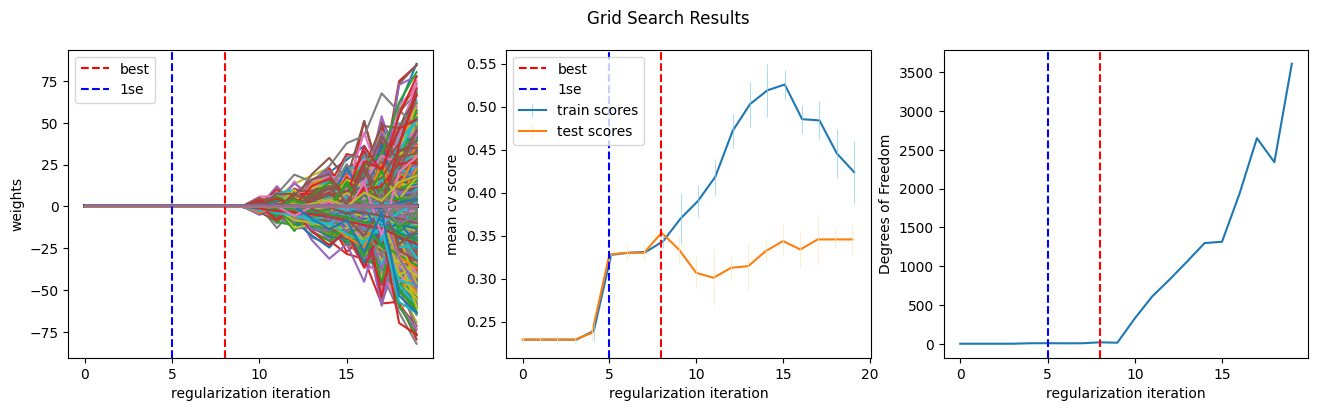

In [53]:
from masterthesis.plots import plot_grid_search
_ = plot_grid_search(sgd)

In [11]:
from masterthesis.model_selection import RegularizationGridSearch
from masterthesis.model import SGDBinarizedModel, LinearBinarizedModel
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer, log_loss

reg_params = np.geomspace(1, 500, 20)
#reg_params = np.geomspace(1, 0.001, 20)
weights_train = calculate_weights(y_train)
scoring = make_scorer(accuracy_score)
fit_params = {"sample_weight": weights_train}
estimator_params = None #{"max_iter": 20}

fit_params = {}
estimator_params = {}

lin = RegularizationGridSearch(estimator=LinearBinarizedModel, n_folds=5, n_jobs=2, lambdas=reg_params, scoring=scoring)
lin.fit(X_train, y_train, fit_params=fit_params, estimator_params=estimator_params)

Best idx: 8 Best Score: 0.43106796116504853 Best Lambda: 13.690156816728805 Scores std: 0.039265093566876075
1SE idx: 8 1SE Score: 0.43106796116504853 1SE Lambda: 13.690156816728805


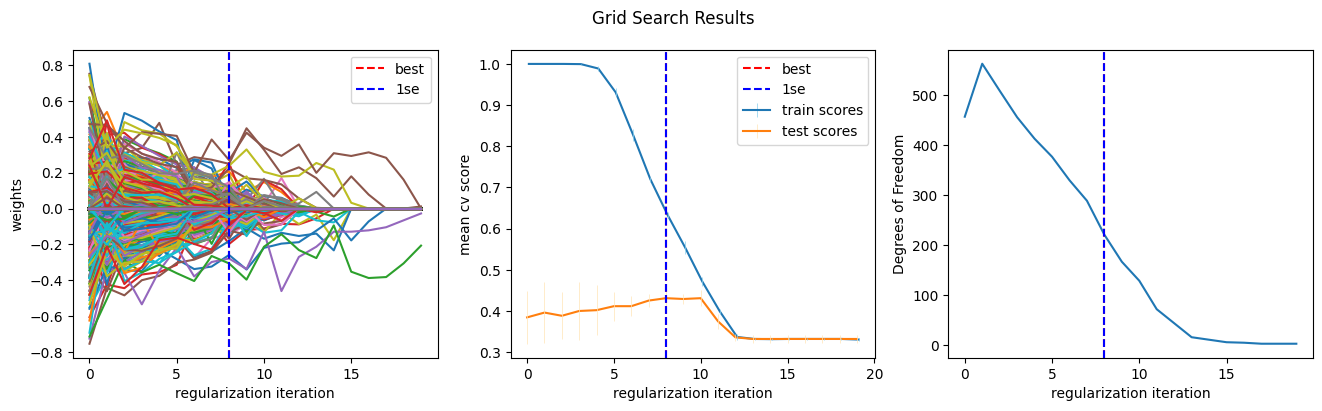

In [12]:
from masterthesis.plots import plot_grid_search
_ = plot_grid_search(lin)

In [62]:
sparse_model = sgd.get_optimal_model("best")
sparse_model.fit(X_train, y_train)

SGDBinarizedModel(regularization=0.0545559478116852)

Degrees of freedom 8
Train:
Accuracy: 0.3300970873786408
Balanced accuracy: 0.2830188679245283
Mean absolute delta: 1.472730389635834
Test:
Accuracy: 0.3275862068965517
Balanced accuracy: 0.2857142857142857
Mean absolute delta: 1.4263565891472871


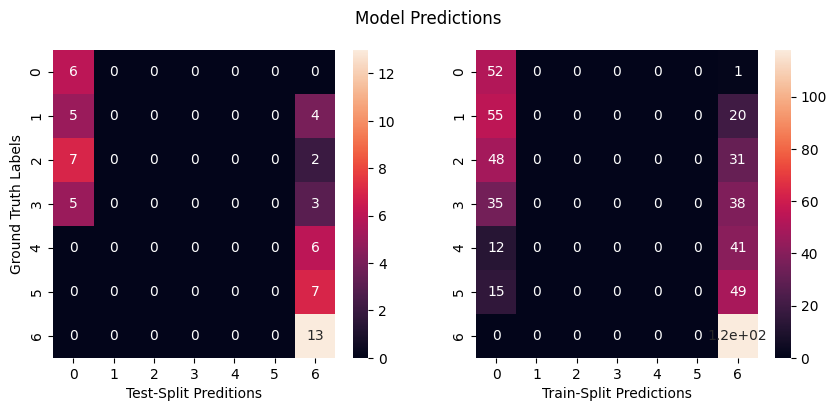

In [63]:
from masterthesis.plots import plot_model_perf
_ = plot_model_perf(sparse_model, test=(X_test, y_test), train=(X_train, y_train))

In [65]:
sparse_model.predict_psuper(anndata)
anndata.var["psupertime_weights"] = sparse_model.coef_

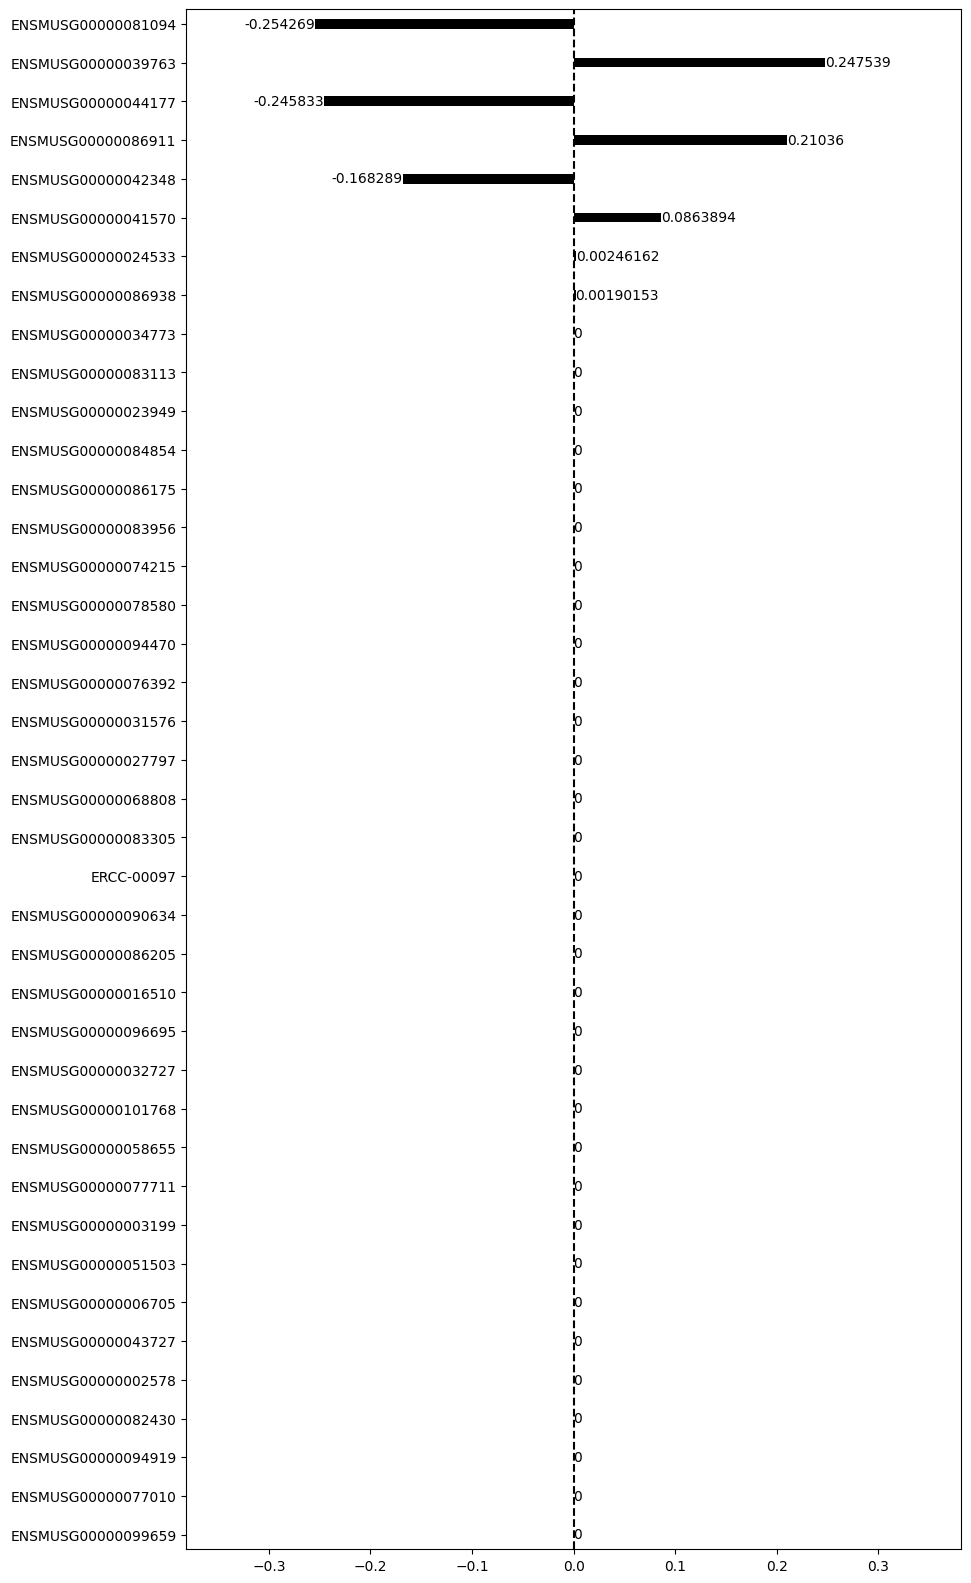

In [66]:
from masterthesis.plots import plot_identified_gene_coefficients

_ = plot_identified_gene_coefficients(sparse_model, anndata, n_top=40, figsize=(10,20))

# Plot labels over psupertime

In [64]:
print(sparse_model.intercept_)
print(sparse_model.binary_estimator_.intercept_)

[0.66908556 0.27502585 0.27502585 0.27502585 0.27502585 0.27502585]
[0.27502585]


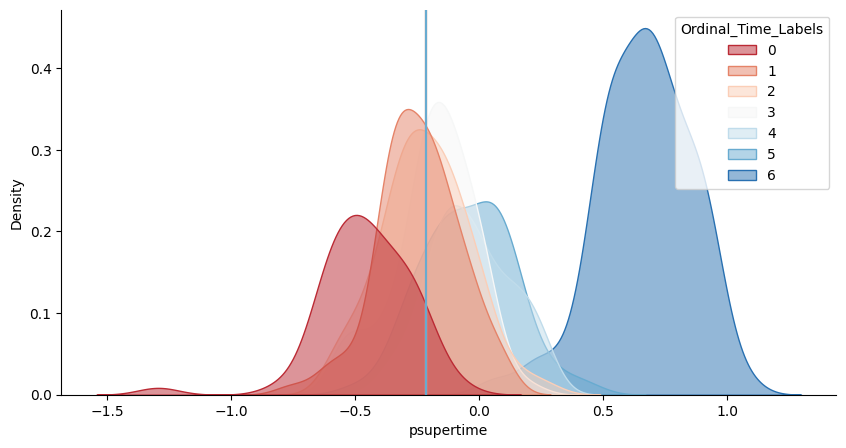

In [58]:
from masterthesis.plots import plot_labels_over_psupertime

_ = plot_labels_over_psupertime(sparse_model, anndata, "Ordinal_Time_Labels")


# Correlation with true latent time

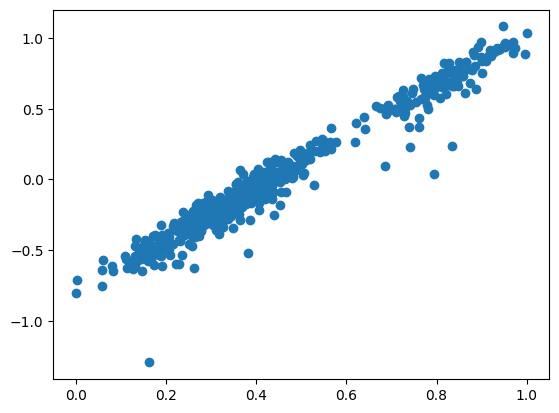

In [94]:
plt.scatter(anndata.obs.Latent_Time, psupertime)

In [97]:
pearsonr = anndata.obs.Latent_Time.corr(anndata.obs.psupertime)
spearmanr = anndata.obs.Latent_Time.corr(anndata.obs.psupertime, method='spearman')
kendalltau = anndata.obs.Latent_Time.corr(anndata.obs.psupertime, method='kendall')
print("Pearson's correlation:", pearsonr)
print("Spearman's correlation:", spearmanr)
print("Kenall Tau:", kendalltau)

Pearson's correlation: 0.9957286999687694
Spearman's correlation: 0.9938819959251579
Kenall Tau: 0.938942383968562
